#  Homework 5 - Berkeley STAT 157

**Your name: Zhiming, SID 3034485754** (Please add your name, and SID to ease Ryan and Rachel to grade.)

**Please submit your homework through [gradescope](http://gradescope.com/) instead of Github, so you will get the score distribution for each question. Please enroll in the [class](https://www.gradescope.com/courses/42432) by the Entry code: MXG5G5** 

Handout 2/19/2019, due 2/26/2019 by 4pm in Git by committing to your repository.

In this homework, we will model covariate shift and attempt to fix it using logistic regression. This is a fairly realistic scenario for data scientists. To keep things well under control and understandable we will use [Fashion-MNIST](http://d2l.ai/chapter_linear-networks/fashion-mnist.html) as the data to experiment on. 

Follow the instructions from the Fashion MNIST notebook to get the data.

In [1]:
%matplotlib inline
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import d2l
import numpy as np
import matplotlib.pyplot as plt
import mxnet as mx
import time

## 1. Logistic Regression

1. Implement the logistic loss function $l(y,f) = -\log(1 + \exp(-y f))$ in Gluon.
2. Plot its values and its derivative for $y = 1$ and $f \in [-5, 5]$, using automatic differentiation in Gluon.
3. Generate training and test datasets for a binary classification problem using Fashion-MNIST with class $1$ being a combination of `shirt` and `sweater` and class $-1$ being the combination of `sandal` and `sneaker` categories. 
4. Train a binary classifier of your choice (it can be linear or a simple MLP such as from a previous lecture) using half the data (i.e. $12,000$ observations mixed as abvove) and one using the full dataset (i.e. $24,000$ observations as arising from the 4 categories) and report its accuracy. 

Hint - you should encapsulate the training and reporting code in a callable function since you'll need it quite a bit in the following. 

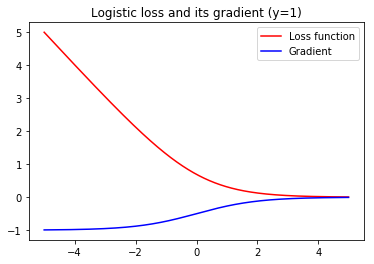

In [2]:
# for question 1 & 2
def logistic_loss(f, y):
    l = nd.log(1.0+nd.exp(-f*y))
    return l
f = nd.arange(-5, 5, 0.01)
f.attach_grad()
# for y = 1
y = nd.ones(shape = f.shape)
with autograd.record():
    l = logistic_loss(f, y)
l.backward()
# for loss function
plt.figure()
plt.title('Logistic loss and its gradient (y=1)')
plt.plot(f.asnumpy(), l.asnumpy(), color = 'r',\
         label = 'Loss function')
# for grad
plt.plot(f.asnumpy(), f.grad.asnumpy(), color = 'b',\
        label = 'Gradient')
plt.legend(loc = 'upper right')
plt.show()

In [3]:
mnist_train = gdata.vision.FashionMNIST(train=True, transform = lambda data, label:\
                                        (data.astype(np.float32), label))
mnist_test = gdata.vision.FashionMNIST(train=False, transform = lambda data, label:\
                                        (data.astype(np.float32), label))

In [4]:
# for question 3
#X, y = train[0:9]
# pick out pullover/shirt, and sneaker/scandal
# a new preprocess function, can produce biased dataset
def preprocess(mnist_train, mnist_test, total_per_label, ratio): # ratio is the lambda above
    X, y = mnist_train[:]
    # pick up the indices
    index_sweater = np.where(y==3)[0]
    index_shirt = np.where(y==6)[0]
    index_scandal = np.where(y==5)[0]
    index_sneaker = np.where(y==7)[0]
    # create the class for training, biased
    class_sweater = X[index_sweater[0:round(total_per_label*ratio)]]
    class_sneaker = X[index_sneaker[0:round(total_per_label*ratio)]]
    class_scandal = X[index_scandal[0:round(total_per_label*(1-ratio))]]
    class_shirt = X[index_shirt[0:round(total_per_label*(1-ratio))]]
    # print(class_sweater.shape, class_shirt.shape, class_scandal.shape, class_sneaker.shape)
    train_feature = nd.concat(class_sweater, class_shirt, class_scandal, class_sneaker, dim=0)
    label1 = nd.ones((1, round(total_per_label*2*ratio))).astype(np.float32)
    label2 = nd.zeros((1, round(total_per_label*2*(1-ratio)))).astype(np.float32)
    train_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    train_data = gdata.dataset.ArrayDataset(train_feature, train_labels)
    # create the class for testing, unbiased
    X, y = mnist_test[:]
    index1 = np.where(np.logical_or(y==3, y==6))[0]
    index2 = np.where(np.logical_or(y==5, y==7))[0]
    class1 = X[index1]
    class2 = X[index2]
    test_feature = nd.concat(class1, class2, dim=0)
    
    label1 = nd.ones((1, 2000)).astype(np.float32)
    label2 = nd.zeros((1, 2000)).astype(np.float32)
    test_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    test_data = gdata.dataset.ArrayDataset(test_feature, test_labels)
    
    return train_data, test_data

In [5]:
def train_and_test_mnist(train_data, test_data, batch_size, lr, num_epochs):
    net = nn.Sequential()
    net.add(nn.Dense(2))
    net.initialize(init.Normal(sigma=0.01))
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    #loss = logistic_loss
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    d2l.train_ch3(net, train_data, test_data, loss, num_epochs, batch_size, None, None, trainer)

In [6]:
# half the dataset 
# note: use half the dataset, test acc is almost the same as using the full dataset
# so I used just 50 per label for train (total 100 for training), which leads to
# observable difference in test acc (~.975 v.s. ~.999)
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=50, ratio=0.5) # ratio=.5 for equally division
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.1, num_epochs=5)
# full dataset
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=12000, ratio=0.5) # ration=.5 for equally division
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.1, num_epochs=5)

epoch 1, loss 26718.0885, train acc 0.660, test acc 0.526
epoch 2, loss 11235.9929, train acc 0.670, test acc 0.975
epoch 3, loss 11.1763, train acc 0.990, test acc 0.980
epoch 4, loss 0.0000, train acc 1.000, test acc 0.980
epoch 5, loss 0.0000, train acc 1.000, test acc 0.980
epoch 1, loss 435.3934, train acc 0.992, test acc 0.997
epoch 2, loss 44.4580, train acc 0.998, test acc 0.999
epoch 3, loss 26.6787, train acc 0.999, test acc 0.999
epoch 4, loss 17.2049, train acc 0.999, test acc 0.999
epoch 5, loss 15.4026, train acc 0.999, test acc 0.999


## 2. Covariate Shift

Your goal is to introduce covariate shit in the data and observe the accuracy. For this, compose a dataset of $12,000$ observations, given by a mixture of `shirt` and `sweater` and of `sandal` and `sneaker` respectively, where you use a fraction $\lambda \in \{0.05, 0.1, 0.2, \ldots 0.8, 0.9, 0.95\}$ of one and a fraction of $1-\lambda$ of  the other datasets respectively. For instance, you might pick for $\lambda = 0.1$ a total of $600$ `shirt` and $600$ `sweater` images and likewise $5,400$ `sandal` and $5,400$ `sneaker` photos, yielding a total of $12,000$ images for training. Note that the test set remains unbiased, composed of $2,000$ photos for the `shirt` + `sweater` category and of the `sandal` + `sneaker` category each.

1. Generate training sets that are appropriately biased. You should have 11 datasets.
2. Train a binary classifier using this and report the test set accuracy on the unbiased test set. 

In [7]:
total_per_label = 6000
num_epochs = 8
print("Bias ratio now is:", .05)
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=total_per_label, ratio=0.05)
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.01, num_epochs=num_epochs)
for r in range(1, 9, 1):
    ratio = r / 10.0
    print("Bias ratio now is:", ratio, "(unbiased)" if ratio==.5 else "")
    train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=total_per_label, ratio=ratio)
    batch_size = 64
    train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.01, num_epochs=num_epochs)
print("Bias ratio now is:", .95)
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=total_per_label, ratio=0.95)
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.01, num_epochs=num_epochs)

Bias ratio now is: 0.05
epoch 1, loss 1000.1986, train acc 0.924, test acc 0.724
epoch 2, loss 724.9604, train acc 0.934, test acc 0.714
epoch 3, loss 743.7490, train acc 0.935, test acc 0.695
epoch 4, loss 698.5812, train acc 0.934, test acc 0.505
epoch 5, loss 630.6260, train acc 0.940, test acc 0.697
epoch 6, loss 655.4589, train acc 0.938, test acc 0.718
epoch 7, loss 689.7992, train acc 0.935, test acc 0.742
epoch 8, loss 739.3488, train acc 0.934, test acc 0.672
Bias ratio now is: 0.1 
epoch 1, loss 1718.0855, train acc 0.872, test acc 0.655
epoch 2, loss 1478.2894, train acc 0.882, test acc 0.599
epoch 3, loss 1485.8477, train acc 0.887, test acc 0.799
epoch 4, loss 1429.8997, train acc 0.888, test acc 0.642
epoch 5, loss 1307.3289, train acc 0.888, test acc 0.538
epoch 6, loss 1196.0399, train acc 0.890, test acc 0.933
epoch 7, loss 1389.5948, train acc 0.889, test acc 0.757
epoch 8, loss 1321.6712, train acc 0.890, test acc 0.578
Bias ratio now is: 0.2 
epoch 1, loss 2631.4459

## 3. Covariate Shift Correction

Having observed that covariate shift can be harmful, let's try fixing it. For this we first need to compute the appropriate propensity scores $\frac{dp(x)}{dq(x)}$. For this purpose pick a biased dataset, let's say with $\lambda = 0.1$ and try to fix the covariate shift.

1. When training a logistic regression binary classifier to fix covariate shift, we assumed so far that both sets are of equal size. Show that re-weighting data in training and test set appropriately can help address the issue when both datasets have different size. What is the weighting?
2. Train a binary classifier (using logistic regression) distinguishing between the biased training set and the unbiased test set. Note - you need to weigh the data. 
3. Use the scores to compute weights on the training set. Do they match the weight arising from the biasing distribution $\lambda$? 
4. Train a binary classifier of the covariate shifted problem using the weights obtained previously and report the accuracy. Note - you will need to modify the training loop slightly such that you can compute the gradient of a weighted sum of losses. 


#### Answer
1. We need to minimize the loss function when the data come from a unbiased dataset, where the label x has a distribution function $p(x)$: 
$$\min_w\int{dxp(x)}\int{dyp(y|x)l(f(x,w),y)}$$
where $p(x)$ is the 'correct' distribution of label $x$ and $q(x)$ is biased.   
While the empirical form could be descirbed as:
$$\min_x\frac{1}{n}\sum_{i}(l(x_i,y_i),f(x_i))$$
When the data come from biased dataset (here is the training set, where $x$ has the distribution $q(x)$, the formula becomes:
$$\min_w\int{dxq(x)}\int{dyp(y|x)l(f(x,w),y)}$$
So re-weighting data to adjust the $q(x)$ back to $p(x)$ would help the function become unbiased. Therefore, the weight when training the binary classification should be:
$$\beta(x) = \frac{p(x)}{q(x)} $$
The joint probability distribution is (label data from train as -1, from test as 1:
$$r(x,y) = \frac{N_{test}}{N}p(x)\delta(y,1) + \frac{N_{train}}{N}q(x)\delta(y,-1)$$
$$r(y = 1|x) = \frac{r(x,y=1)}{r(x)} = \frac{r(x,y=1)}{r(x|y=1) + r(x|y=-1)} = \frac{r(x,y=1)}{r(x, y=1) + r(x, y=-1)} = \frac{N_{test}p(x)}{N_{test}p(x)+N_{train}q(x)}$$
$$r(y = -1|x) = \frac{r(x,y=-1)}{r(x)} = \frac{r(x,y=-1)}{r(x|y=-1) + r(x|y=1)} = \frac{r(x,y=-1)}{r(x, y=1) + r(x, y=-1)} = \frac{N_{train}q(x)}{N_{test}p(x)+N_{train}q(x)}$$
$$\beta(x) = \frac{p(x)}{q(x)} = \frac{r(y = 1|x)}{r(y = -1|x)}*\frac{N_{train}}{N_{test}} = \frac{N_{train}}{N_{test}} exp(f(x))$$
Therefore, the weight is: $$\frac{N_{train}}{N_{test}}exp(f(x))$$

### For question 2, weighted loss for training

In [8]:
# preperations
def logistic(z):
    return 1. / (1. + nd.exp(-z))
# loss function, with weight
def log_loss(output, y, ratio):
    yhat = logistic(output)
    yhat = yhat.reshape(shape=y.shape)
    # biased loss
    return  - nd.nansum((1-ratio)/(.5+ratio) * y * nd.log(yhat) + ratio/(.5+ratio) * (1-y) * nd.log(1-yhat))
    # original loss
    # return  - nd.nansum(y * nd.log(yhat) + (1-y) * nd.log(1-yhat))
# train_model
def train_model(epochs, train_data, net, trainer, batch_size, ratio, f=None):
    for e in range(epochs):
        cumulative_loss = 0
        for i, (data, label) in enumerate(train_data):
            with autograd.record():
                if f is not None:
                    ratio = f(data)
                    print('now the ratio is:', ratio)
                output = net(data)
                # print('weigth of net:', net.bias.data(), net.weight.data())
                # print('output of net:', output)
                loss = log_loss(output, label, ratio)
            loss.backward()
            trainer.step(batch_size)
            cumulative_loss += nd.sum(loss).asscalar()
        print("Epoch %s, loss: %s" % (e + 1, cumulative_loss ))
# test_model
def test_model(test_data):
    num_correct = 0.0
    num_total = 0
    for i, (data, label) in enumerate(test_data):
        num_total += len(label)
        output = net(data)
        # visual = nd.concat(output.reshape(shape=(64,1)), label.reshape(shape=(64,1)), dim=1)
        # print(visual)
        prediction = ((nd.sign(output).reshape(shape=label.shape) + 1) / 2)
        num_correct += nd.sum(prediction == label)
    print("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))

In [9]:
# combine train and test
def train_and_test_mnist_ratio(train_data, test_data, net, trainer, num_epochs, batch_size, ratio):
    train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label, ratio)
    train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    train_model(num_epochs, train_data, net, trainer, batch_size, ratio)
    test_model(test_data)

In [10]:
def preprocess(mnist_train, mnist_test, total_per_label, ratio): # ration is the lambda above
    X, y = mnist_train[:]
    # pick up the indices
    index_sweater = np.where(y==3)[0]
    index_shirt = np.where(y==6)[0]
    index_scandal = np.where(y==5)[0]
    index_sneaker = np.where(y==7)[0]
    # create the class for training, biased
    class_sweater = X[index_sweater[0:round(total_per_label*ratio)]]
    class_shirt = X[index_shirt[0:round(total_per_label*ratio)]]
    class_scandal = X[index_scandal[0:round(total_per_label*(1-ratio))]]
    class_sneaker = X[index_sneaker[0:round(total_per_label*(1-ratio))]]
    # print(class_sweater.shape, class_shirt.shape, class_scandal.shape, class_sneaker.shape)
    train_feature = nd.concat(class_sweater, class_shirt, class_scandal, class_sneaker, dim=0)
    train_feature = nd.flatten(train_feature)
    label = nd.ones((1, total_per_label*2)).astype(np.float32)
    train_labels = label.reshape(shape=(-1,))
    train_data = gdata.dataset.ArrayDataset(train_feature, train_labels)
    # create the class for testing, unbiased
    X, y = mnist_test[:]
    index1 = np.where(np.logical_or(y==3, y==6))[0]
    index2 = np.where(np.logical_or(y==5, y==7))[0]
    class1 = X[index1]
    class2 = X[index2]
    test_feature = nd.concat(class1, class2, dim=0)
    test_feature = nd.flatten(test_feature)
    label = nd.zeros((1, 4000)).astype(np.float32)
    test_labels = label.reshape(shape=(-1,))
    test_data = gdata.dataset.ArrayDataset(test_feature, test_labels)
    return train_data, test_data
def generator(ratio, batch_size):
    mnist_train = gdata.vision.FashionMNIST(train=True,transform=lambda data, label: (data.astype(np.float32)/255.0, label))
    mnist_test = gdata.vision.FashionMNIST(train=False,transform=lambda data, label: (data.astype(np.float32)/255.0, label))
    bias_train, bias_test = preprocess(mnist_train, mnist_test, 6000, ratio)
    #train's label should be 1 and test's label should be 0
    f_train, l_train = bias_train[:]
    f_test, l_test = bias_test[:]
    
    l_train = nd.ones((1, 12000)).astype(np.float32)
    l_test = nd.zeros((1,4000)).astype(np.float32)
    
    trainLabel = nd.concat(l_train[:,:8000],l_test[:,:3000],dim = 1).reshape(shape=(-1,))
    testLabel = nd.concat(l_train[:,8000:],l_test[:,3000:],dim = 1).reshape(shape=(-1,))
    trainFeature = nd.concat(f_train[:8000], f_test[:3000], dim = 0)
    testFeature = nd.concat(f_train[8000:], f_test[3000:], dim = 0)

    train_data = gdata.dataset.ArrayDataset(trainFeature, trainLabel) 
    test_data = gdata.dataset.ArrayDataset(testFeature, testLabel) 
    return train_data, test_data

In [11]:
mnist_train = gdata.vision.FashionMNIST(train=True, transform = lambda data, label:\
                                        (data.astype(np.float32)/255.0, label))
mnist_test = gdata.vision.FashionMNIST(train=False, transform = lambda data, label:\
                                        (data.astype(np.float32)/255.0, label))
net = nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=.1))
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
batch_size = 64
num_epochs = 80
ratio = 0.1
train_data, test_data = generator(ratio, batch_size)
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_model(num_epochs, train_data, net, trainer, batch_size, 3./11)
test_model(test_data)
# this is the weight function we want, save to use later

Epoch 1, loss: 3574.4570150375366
Epoch 2, loss: 3151.593458175659
Epoch 3, loss: 3070.2279958724976
Epoch 4, loss: 3023.494716644287
Epoch 5, loss: 2990.501064300537
Epoch 6, loss: 2964.288585662842
Epoch 7, loss: 2943.6569423675537
Epoch 8, loss: 2925.1764526367188
Epoch 9, loss: 2907.9407787323
Epoch 10, loss: 2893.4413805007935
Epoch 11, loss: 2879.601933479309
Epoch 12, loss: 2867.217098236084
Epoch 13, loss: 2856.6793184280396
Epoch 14, loss: 2846.189125061035
Epoch 15, loss: 2836.723868370056
Epoch 16, loss: 2826.2606382369995
Epoch 17, loss: 2817.787402153015
Epoch 18, loss: 2810.8221797943115
Epoch 19, loss: 2804.0963249206543
Epoch 20, loss: 2796.3563499450684
Epoch 21, loss: 2788.6778297424316
Epoch 22, loss: 2783.7293033599854
Epoch 23, loss: 2777.1588201522827
Epoch 24, loss: 2771.2103633880615
Epoch 25, loss: 2766.2930002212524
Epoch 26, loss: 2760.329577445984
Epoch 27, loss: 2756.365584373474
Epoch 28, loss: 2751.379147529602
Epoch 29, loss: 2747.0357389450073
Epoch 30,

In [12]:
bias_train, bias_test = preprocess(mnist_train, mnist_test, 6000, .2)
X, y = bias_train[:]
weight = nd.clip(nd.exp(net(X)), 0.01, 10)
weight


[[ 1.1918093]
 [ 1.629158 ]
 [ 1.3973526]
 ...
 [10.       ]
 [ 8.610544 ]
 [10.       ]]
<NDArray 12000x1 @cpu(0)>

In [18]:
def logistic(z):
    return 1. / (1. + nd.exp(-z))
    
log_loss = gluon.loss.SigmoidBCELoss()

def train_model2(epochs, train_data, net, trainer, batch_size, weight):
    for e in range(epochs):
        cumulative_loss = 0
        for i, (data, label) in enumerate(train_data):
            with autograd.record():
                output = net(data)
                loss = log_loss(output, label) * weight[i]
            loss.backward()
            trainer.step(batch_size)
            cumulative_loss += nd.sum(loss).asscalar()
        print("Epoch %s, loss: %s" % (e, cumulative_loss ))


def test_model2(test_data):
    num_correct = 0.0
    num_total = 0
    for i, (data, label) in enumerate(test_data):
        num_total += len(label)
        output = net(data)
        prediction = ((nd.sign(output).reshape(shape=label.shape) + 1) / 2)
        print(prediction, label)
        num_correct += nd.sum(prediction == label)
    print("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))
    
def train_and_test2(num_epochs, train_data, test_data, net, trainer, batch_size,weight):
    train_model2(num_epochs, train_data, net, trainer, batch_size, weight)
    test_model2(test_data)

In [ ]:
batch_size = 64
total_per_label = 6000
ratio = 0.2
epochs = 20
net = nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=.01))
train_half, test_half = preprocess(mnist_train, mnist_test, 6000, .2)

Train = gluon.data.DataLoader(train_half, batch_size=batch_size, shuffle=True)
Test = gluon.data.DataLoader(test_half, batch_size=batch_size, shuffle=True)

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.03})

train_and_test2(epochs, Train, Test, net, trainer, batch_size, weight)

Epoch 0, loss: 565.9007399380207
Epoch 1, loss: 118.97194454073906
Epoch 2, loss: 75.83279372006655
Epoch 3, loss: 59.050801530480385
Epoch 4, loss: 46.81203496828675
Epoch 5, loss: 39.33303553238511
Epoch 6, loss: 34.71780950203538
Epoch 7, loss: 30.44540436565876
Epoch 8, loss: 27.782626791857183
Epoch 9, loss: 24.868723805993795
Epoch 10, loss: 22.802089791744947
Epoch 11, loss: 20.772971882484853
Epoch 12, loss: 19.818741157650948
